In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install jiwer
!pip install datasets
!pip install evaluate
!pip install -U accelerate
!pip install matplotlib
!pip install protobuf
!pip install tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install albumentations

Preprocessing the GNHK Dataset

In [ ]:
!python preprocess_gnhk_dataset.py

Traceback (most recent call last):
  File "/content/preprocess_gnhk_dataset.py", line 66, in <module>
    main()
  File "/content/preprocess_gnhk_dataset.py", line 54, in main
    process_dataset(
  File "/content/preprocess_gnhk_dataset.py", line 26, in process_dataset
    for filename in tqdm(os.listdir(input_folder), desc=f"Processing {os.path.basename(input_folder)}"):
                         ^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'input/gnhk_dataset/train_data/train'


In [ ]:
# สั่งแตกไฟล์ test_data.zip ไปไว้ในโฟลเดอร์ที่ถูกต้อง
!unzip -q /content/test_data.zip -d input/gnhk_dataset/test_data

In [ ]:
# สั่งแตกไฟล์ train_data.zip ไปไว้ในโฟลเดอร์ที่ถูกต้อง
!unzip -q /content/train_data.zip -d input/gnhk_dataset/train_data

In [ ]:
import os
import json
import csv
import cv2
import numpy as np
from tqdm import tqdm

def create_directories():
   dirs = [
       'input/gnhk_dataset/train_processed/images',
       'input/gnhk_dataset/test_processed/images',
   ]
   for dir_path in dirs:
       os.makedirs(dir_path, exist_ok=True)

def polygon_to_bbox(polygon):
   points = np.array([(polygon[f'x{i}'], polygon[f'y{i}']) for i in range(4)], dtype=np.int32)
   x, y, w, h = cv2.boundingRect(points)
   return x, y, w, h

def process_dataset(input_folder, output_folder, csv_path):
   with open(csv_path, 'w', newline='') as csvfile:
       csv_writer = csv.writer(csvfile)
       csv_writer.writerow(['image_filename', 'text'])

       for filename in tqdm(os.listdir(input_folder), desc=f"Processing {os.path.basename(input_folder)}"):
           if filename.endswith('.json'):
               json_path = os.path.join(input_folder, filename)
               img_path = os.path.join(input_folder, filename.replace('.json', '.jpg'))

               with open(json_path, 'r') as f:
                   data = json.load(f)

               img = cv2.imread(img_path)

               for idx, item in enumerate(data):
                   text = item['text']
                   if text.startswith('%') and text.endswith('%'):
                       text = 'SPECIAL_CHARACTER'

                   x, y, w, h = polygon_to_bbox(item['polygon'])

                   cropped_img = img[y:y+h, x:x+w]

                   output_filename = f"{filename.replace('.json', '')}_{idx}.jpg"
                   output_path = os.path.join(output_folder, output_filename)
                   cv2.imwrite(output_path, cropped_img)

                   csv_writer.writerow([output_filename, text])

def main():
   create_directories()

   process_dataset(
       'input/gnhk_dataset/train_data/train',
       'input/gnhk_dataset/train_processed/images',
       'input/gnhk_dataset/train_processed.csv'
   )
   process_dataset(
       'input/gnhk_dataset/test_data/test',
       'input/gnhk_dataset/test_processed/images',
       'input/gnhk_dataset/test_processed.csv'
   )

if __name__ == '__main__':
   main()

Processing test: 100%|██████████| 344/344 [00:13<00:00, 25.78it/s]


Fine Tuning TrOCR for Handwritten Text Recognition

In [ ]:
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from transformers import (
   VisionEncoderDecoderModel,
   TrOCRProcessor,
   Seq2SeqTrainer,
   Seq2SeqTrainingArguments,
   default_data_collator
)

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

os.environ["TOKENIZERS_PARALLELISM"] = 'false'

In [ ]:
def seed_everything(seed_value):
   np.random.seed(seed_value)
   torch.manual_seed(seed_value)
   torch.cuda.manual_seed_all(seed_value)
   torch.backends.cudnn.deterministic = True
   torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Training and Dataset Configurations for Handwritten Text Recognition


In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
   BATCH_SIZE:    int = 16
   EPOCHS:        int = 10
   LEARNING_RATE: float = 0.00002

@dataclass(frozen=True)
class DatasetConfig:
   DATA_ROOT:     str = 'input/gnhk_dataset'

@dataclass(frozen=True)
class ModelConfig:
   MODEL_NAME: str = 'microsoft/trocr-small-handwritten'

เพิ่ม Data Augmentation

In [ ]:
import albumentations as A
import numpy as np
from PIL import Image

# 1. ประกาศ Pipeline การ Augmentation ของเรา
# (เราเลือกใช้ค่าที่ "เบาๆ" เพื่อไม่ให้ลายมือเพี้ยนจนอ่านไม่ออก)
train_aug_pipeline = A.Compose([
    # หมุนภาพเล็กน้อย (+/- 3 องศา) โอกาส 50%
    A.Rotate(limit=3, p=0.5),

    # บิดเบือนภาพเล็กน้อย (เหมือนคลื่น)
    A.OpticalDistortion(distort_limit=0.05, p=0.3),

    # เพิ่ม Noise (จุดรบกวน)
    A.GaussNoise(p=0.3),

    # ปรับความสว่าง/ความคมชัดเล็กน้อย
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
])

# 2. สร้างฟังก์ชันสำหรับ *Training Set* (มี Augmentation)
# (ฟังก์ชันนี้จะถูกเรียกทุกครั้งที่ดึงข้อมูลไปเทรน)
def apply_train_augmentations(batch):
    images = []
    # ดึงภาพจาก path
    for img_path in batch['image_path']:
        img = Image.open(img_path).convert("RGB")

        # --- นี่คือส่วนที่เพิ่มเข้ามา ---
        # 1. แปลง PIL Image เป็น NumPy array (สำหรับ Albumentations)
        img_np = np.array(img)

        # 2. สุ่มใช้ Augmentation ที่เราประกาศไว้
        augmented = train_aug_pipeline(image=img_np)
        img_aug_np = augmented['image']

        images.append(img_aug_np) # ใส่ภาพที่ Augment แล้ว (เป็น NumPy)
        # --- จบส่วนที่เพิ่ม ---

    # 3. ส่งภาพ (ที่อาจจะถูก Augment แล้ว) ไปให้ Processor
    pixel_values = processor(images, return_tensors="pt").pixel_values

    # 4. Tokenize labels
    labels = processor.tokenizer(batch['label'], padding="max_length", truncation=True, max_length=64).input_ids # (ปรับ max_length ตามความเหมาะสม)

    return {"pixel_values": pixel_values, "labels": labels}


# 3. สร้างฟังก์ชันสำหรับ *Validation/Test Set* (ห้าม Augment!)
def preprocess_val(batch):
    # โค้ดนี้เหมือนในบทความเป๊ะๆ คือโหลดภาพและ process เลย
    images = [Image.open(img_path).convert("RGB") for img_path in batch['image_path']]
    pixel_values = processor(images, return_tensors="pt").pixel_values
    labels = processor.tokenizer(batch['label'], padding="max_length", truncation=True, max_length=64).input_ids
    return {"pixel_values": pixel_values, "labels": labels}

Visualizing the Cropped Sample with Labels

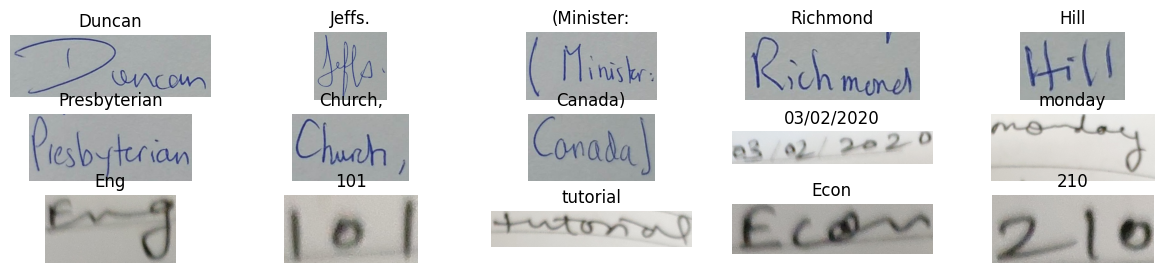

In [ ]:
def visualize(dataset_path, df):
   all_images = df.image_filename
   all_labels = df.text

   plt.figure(figsize=(15, 3))
   for i in range(15):
       plt.subplot(3, 5, i+1)
       image = plt.imread(f"{dataset_path}/test_processed/images/{all_images[i]}")
       label = all_labels[i]
       plt.imshow(image)
       plt.axis('off')
       plt.title(label)
   plt.show()
sample_df = pd.read_csv(
   os.path.join(DatasetConfig.DATA_ROOT, 'test_processed.csv'),
   header=None,
   skiprows=1,
   names=['image_filename', 'text'],
   nrows=50
)

visualize(DatasetConfig.DATA_ROOT, sample_df)

GNHK Dataset Preparation

In [ ]:
train_df = pd.read_csv(
   os.path.join(DatasetConfig.DATA_ROOT, 'train_processed.csv'),
   header=None,
   skiprows=1,
   names=['image_filename', 'text']
)


test_df = pd.read_csv(
   os.path.join(DatasetConfig.DATA_ROOT, 'test_processed.csv'),
   header=None,
   skiprows=1,
   names=['image_filename', 'text']
)

In [ ]:
# Augmentations.
train_transforms = transforms.Compose([
   transforms.ColorJitter(brightness=.5, hue=.3),
   transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5)),
])

In [ ]:
class CustomOCRDataset(Dataset):
   def __init__(self, root_dir, df, processor, max_target_length=128):
       self.root_dir = root_dir
       self.df = df
       self.processor = processor
       self.max_target_length = max_target_length


       self.df['text'] = self.df['text'].fillna('')


   def __len__(self):
       return len(self.df)


   def __getitem__(self, idx):
       # The image file name.
       file_name = self.df['image_filename'][idx]
       # The text (label).
       text = self.df['text'][idx]

       # Read the image, apply augmentations, and get the transformed pixels.
       image = Image.open(self.root_dir + file_name).convert('RGB')
       image = train_transforms(image)
       pixel_values = self.processor(image, return_tensors='pt').pixel_values
       # Pass the text through the tokenizer and get the labels,
       # i.e. tokenized labels.
       labels = self.processor.tokenizer(
           text,
           padding='max_length',
           max_length=self.max_target_length
       ).input_ids
       # We are using -100 as the padding token.
       labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
       encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
       return encoding

In [ ]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
train_dataset = CustomOCRDataset(
   root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'train_processed/images/'),
   df=train_df,
   processor=processor
)
valid_dataset = CustomOCRDataset(
   root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'test_processed/images/'),
   df=test_df,
   processor=processor
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

Initializing and Configuring the Model

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
   p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=384, out_features=1536, bias=True)
        

In [ ]:
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id

model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
optimizer = optim.AdamW(
   model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

## Start Training the Fine-tuned TrOCR Model

This cell will initiate the training process for the TrOCR model using the `Seq2SeqTrainer`.

In [ ]:
res = trainer.train()

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
677,1.196300
1354,0.673700
2031,0.523000
2708,0.420900
3385,0.340200
4062,0.273700
4739,0.215700
5416,0.168900
6093,0.130800
6770,0.103400


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Character Error Rate (CER) – Evaluation Metric

In [ ]:
cer_metric = evaluate.load('cer')


def compute_cer(pred):
   labels_ids = pred.label_ids
   pred_ids = pred.predictions


   pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
   labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
   label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)


   cer = cer_metric.compute(predictions=pred_str, references=label_str)


   return {"cer": cer}

Training and Validation for Handwritten Text Recognition using OCR

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
   predict_with_generate=True,
   # evaluation_strategy='epoch', # Commented out to resolve TypeError
   per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
   per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    gradient_accumulation_steps=3,
   fp16=True,
   output_dir='trocr_handwritten/',
   logging_strategy='epoch',
   save_strategy='epoch',
   save_total_limit=2,
   report_to='tensorboard',
   num_train_epochs=TrainingConfig.EPOCHS,
   dataloader_num_workers=2 # เดิมคือ 8
)

In [ ]:
# Initialize trainer.
trainer = Seq2SeqTrainer(
   model=model,
   tokenizer=processor.feature_extractor,
   args=training_args,
   compute_metrics=compute_cer,
   train_dataset=train_dataset,
   eval_dataset=valid_dataset,
   data_collator=default_data_collator
)

/usr/local/lib/python3.12/dist-packages/transformers/models/trocr/processing_trocr.py:139: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/tmp/ipython-input-729426261.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Inference using the Trained TrOCR Model

In [ ]:
import os

# Define the base output directory
output_dir = 'trocr_handwritten'

# Find all checkpoint directories
checkpoint_dirs = [d for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d)) and d.startswith('checkpoint-')]

if checkpoint_dirs:
    # Sort to get the latest checkpoint by numerical step
    latest_checkpoint_dir = sorted(checkpoint_dirs, key=lambda x: int(x.split('-')[1]))[-1]
    model_load_path = os.path.join(output_dir, latest_checkpoint_dir)

    # Load the processor from the *original* pre-trained model name
    print(f"Loading processor from original model: {ModelConfig.MODEL_NAME}")
    processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)

    # Load the trained model from the latest checkpoint
    print(f"Loading trained model from: {model_load_path}")
    trained_model = VisionEncoderDecoderModel.from_pretrained(model_load_path).to(device)
    print("Trained model loaded successfully from latest checkpoint!")
else:
    print(f"Error: No checkpoint directories found in {output_dir}. Please ensure the training step completed and saved checkpoints.")


Loading processor from original model: microsoft/trocr-small-handwritten
Loading trained model from: trocr_handwritten/checkpoint-6770
Trained model loaded successfully from latest checkpoint!


In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

def read_and_show(image_path):
    """
    :param image_path: String, path to the input image.

    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

def ocr(image, processor, model, device):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.
    :param device: Torch device (cuda or cpu).

    Returns:
        generated_text: the OCR'd text string.
    """
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

def eval_new_data(
    processor_obj,
    model_obj,
    device_obj,
    data_path=None,
    num_samples=50,
    df=None,
    title_prefix=""
):
    all_images = df.image_filename
    all_labels = df.text

    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(3, 5, i+1)
        image = read_and_show(os.path.join(data_path, all_images[i]))
        text = ocr(image, processor_obj, model_obj, device_obj)
        plt.imshow(image)
        plt.title(f"{title_prefix}: {text}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Displaying examples from the Fine-tuned Model:


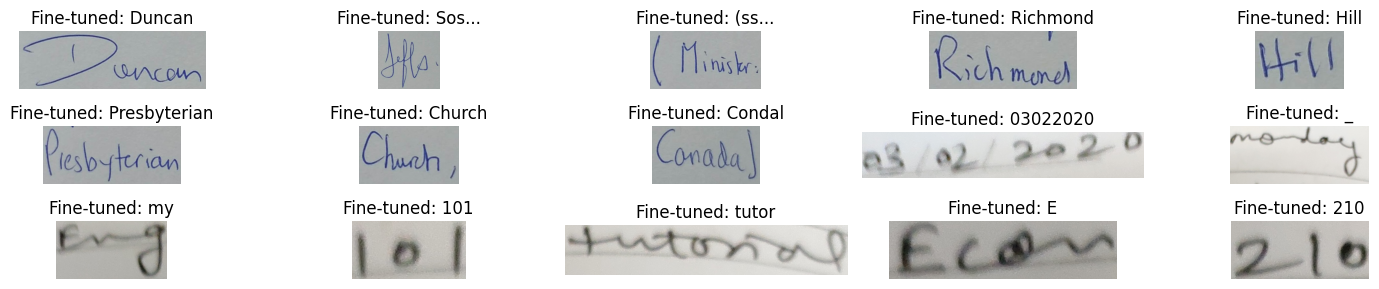

In [ ]:
print("Displaying examples from the Fine-tuned Model:")
eval_new_data(
    processor_obj=processor,
    model_obj=trained_model,
    device_obj=device,
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'test_processed/images'),
    num_samples=15,
    df=sample_df,
    title_prefix="Fine-tuned"
)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Displaying examples from the Pre-trained Model (microsoft/trocr-small-handwritten):


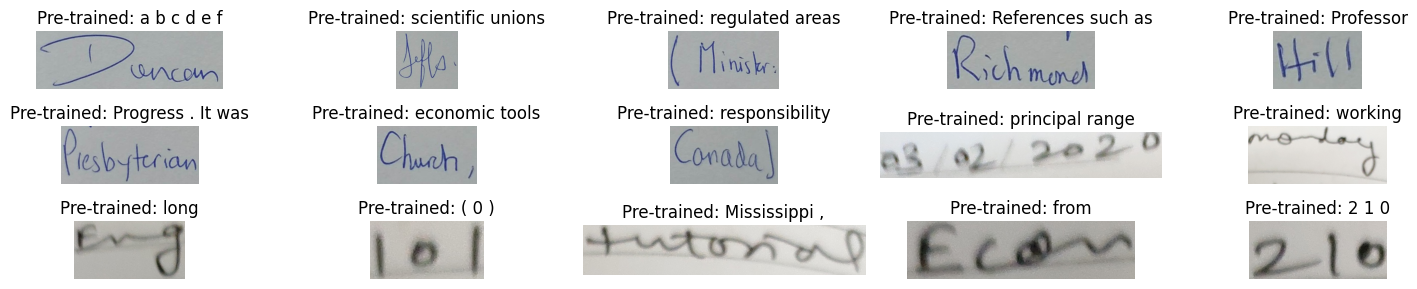

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Ensure device is defined (from previous cells)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained processor and model directly here to avoid NameError
pretrained_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten')
pretrained_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-handwritten').to(device)

print("\nDisplaying examples from the Pre-trained Model (microsoft/trocr-small-handwritten):")
eval_new_data(
    processor_obj=pretrained_processor,
    model_obj=pretrained_model,
    device_obj=device,
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'test_processed/images'),
    num_samples=15,
    df=sample_df,
    title_prefix="Pre-trained"
)

# Task
Compare the Character Error Rate (CER) of the fine-tuned model (`trained_model`) with the pre-trained model (`microsoft/trocr-small-handwritten`) on the `valid_dataset` and display the results.

## Load Pre-trained Model

### Subtask:
โหลดโมเดล `microsoft/trocr-small-handwritten` ที่เป็น pre-trained model เพื่อใช้ในการเปรียบเทียบประสิทธิภาพกับโมเดลที่ fine-tune แล้ว


In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

## Define Evaluation Helper Function

### Subtask:
สร้างฟังก์ชันช่วยในการประเมินประสิทธิภาพของโมเดล โดยจะรับโมเดลและ dataset เพื่อทำการ inference และคำนวณค่า CER (Character Error Rate) โดยใช้ฟังก์ชัน `compute_cer` ที่มีอยู่แล้ว


In [ ]:
import torch
import numpy as np
from tqdm.notebook import tqdm
from dataclasses import dataclass

@dataclass
class PredictionOutput:
    predictions: np.ndarray
    label_ids: np.ndarray

def evaluate_model_cer(model, processor, dataset, device):
    model.eval()  # Set model to evaluation mode
    all_true_labels_ids = []
    all_generated_ids = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for i in tqdm(range(len(dataset)), desc="Evaluating"): # Iterate through individual items
            batch = dataset[i]
            pixel_values = batch["pixel_values"].unsqueeze(0).to(device)  # Add batch dimension (batch_size=1)
            labels = batch["labels"]  # These are already token IDs, typically padded with -100

            generated_ids = model.generate(pixel_values)  # Shape: (1, generated_seq_len)

            all_generated_ids.append(generated_ids.cpu().numpy()) # Store as numpy array
            all_true_labels_ids.append(labels.cpu().numpy()) # Store as numpy array

    # Pad generated IDs to the maximum length found across all predictions
    # This is necessary because model.generate can produce variable-length sequences
    max_gen_len = max(arr.shape[1] for arr in all_generated_ids)
    padded_generated_ids = []
    for gen_id_arr in all_generated_ids:
        pad_width = max_gen_len - gen_id_arr.shape[1]
        # Pad with the tokenizer's pad_token_id
        padded_arr = np.pad(gen_id_arr, ((0, 0), (0, pad_width)), mode='constant', constant_values=processor.tokenizer.pad_token_id)
        padded_generated_ids.append(padded_arr)
    final_generated_ids = np.vstack(padded_generated_ids) # Stack all padded predictions into a single array

    # True labels should already be consistently padded to max_target_length with -100 by CustomOCRDataset
    final_true_labels_ids = np.stack(all_true_labels_ids) # Stack all true labels into a single array

    # Create a dummy PredictionOutput object to match the compute_cer function's expected input
    pred_output = PredictionOutput(predictions=final_generated_ids, label_ids=final_true_labels_ids)

    # Compute CER using the provided function
    cer_result = compute_cer(pred_output)

    return cer_result["cer"]

print("Evaluation helper function `evaluate_model_cer` defined successfully.")

Evaluation helper function `evaluate_model_cer` defined successfully.


## Evaluate Fine-tuned Model Accuracy

### Subtask:
ใช้ฟังก์ชันช่วยที่สร้างขึ้นเพื่อคำนวณค่า CER ของโมเดล `trained_model` (โมเดลที่ fine-tune แล้ว) บน `valid_dataset`


ตัวแปร valid_dataset ก็คือชื่อที่มักจะใช้เรียก Dataset Object ที่สร้างจากชุดข้อมูลทดสอบ (Test Set)

รันเซลล์ที่นิยาม Class และรันเซลล์ส่วนที่อ่านไฟล์ CSV และ สร้างตัวแปร valid_dataset

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

# --- 1. นิยาม Transformations ---
# (นี่คือ `train_transforms` ที่คลาสของคุณเรียกหา)
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    transforms.RandomGrayscale(p=0.1),
])

# --- 2. นิยาม Class (เวอร์ชันที่ถูกต้อง) ---
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128, is_train=False): # <--- เพิ่ม is_train
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.is_train = is_train # <--- เพิ่มบรรทัดนี้

        self.df['text'] = self.df['text'].fillna('')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # The image file name.
        file_name = self.df['image_filename'][idx]
        # The text (label).
        text = self.df['text'][idx]

        # Read the image
        image = Image.open(self.root_dir + file_name).convert('RGB')

        # --- นี่คือส่วนที่ถูกต้อง ---
        # Check if this dataset is for training.
        if self.is_train:
            image = train_transforms(image) # ใช้ transforms เฉพาะตอนเทรน

        pixel_values = self.processor(image, return_tensors='pt').pixel_values

        # Pass the text through the tokenizer
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids

        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
import pandas as pd

# --- 3. อ่านไฟล์ CSV ---
# (ในบทความอาจจะอ่านทั้ง train และ test)
train_df = pd.read_csv('input/gnhk_dataset/train_processed.csv')
test_df = pd.read_csv('input/gnhk_dataset/test_processed.csv')
# (ในบทความอาจจะใช้ชื่อ valid_df = test_df ก็ได้ผลเหมือนกัน)

# --- 4. สร้างตัวแปร Dataset (นี่คือสิ่งที่คุณต้องการ) ---
# (ต้องมั่นใจว่าตัวแปร processor ถูกสร้างไว้ในเซลล์ก่อนหน้าแล้ว)

# สร้าง train_dataset
train_dataset = CustomOCRDataset(
    root_dir='input/gnhk_dataset/train_processed/images/',
    df=train_df,
    processor=processor,
    is_train=True # <--- บอกว่าเป็นชุดเทรน
)

# สร้าง valid_dataset (ตัวที่หายไป)
valid_dataset = CustomOCRDataset(
    root_dir='input/gnhk_dataset/test_processed/images/',
    df=test_df,
    processor=processor,
    is_train=False # <--- บอกว่า *ไม่* ใช่ชุดเทรน (สำคัญมาก)
)

print(f"Created train_dataset with {len(train_dataset)} samples.")
print(f"Created valid_dataset with {len(valid_dataset)} samples.")

Created train_dataset with 32495 samples.
Created valid_dataset with 10066 samples.


# Task
Compare the Character Error Rate (CER) of the fine-tuned model (`trained_model`) and the pre-trained model (`microsoft/trocr-small-handwritten`) on the validation dataset (`valid_dataset`), then summarize and present the comparison results.

## Execute Comprehensive Evaluation

### Subtask:
Evaluate both the fine-tuned and pre-trained TrOCR models on the validation dataset to compare their Character Error Rate (CER).


In [ ]:
import evaluate

cer_metric = evaluate.load('cer')

def compute_cer(pred):
   labels_ids = pred.label_ids
   pred_ids = pred.predictions


   pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
   labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
   label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)


   cer = cer_metric.compute(predictions=pred_str, references=label_str)


   return {"cer": cer}

In [ ]:
import torch
import numpy as np
from tqdm.notebook import tqdm
from dataclasses import dataclass

@dataclass
class PredictionOutput:
    predictions: np.ndarray
    label_ids: np.ndarray

def evaluate_model_cer(model, processor, dataset, device):
    model.eval()  # Set model to evaluation mode
    all_true_labels_ids = []
    all_generated_ids = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for i in tqdm(range(len(dataset)), desc="Evaluating"): # Iterate through individual items
            batch = dataset[i]
            pixel_values = batch["pixel_values"].unsqueeze(0).to(device)  # Add batch dimension (batch_size=1)
            labels = batch["labels"]  # These are already token IDs, typically padded with -100

            generated_ids = model.generate(pixel_values)  # Shape: (1, generated_seq_len)

            all_generated_ids.append(generated_ids.cpu().numpy()) # Store as numpy array
            all_true_labels_ids.append(labels.cpu().numpy()) # Store as numpy array

    # Pad generated IDs to the maximum length found across all predictions
    # This is necessary because model.generate can produce variable-length sequences
    max_gen_len = max(arr.shape[1] for arr in all_generated_ids)
    padded_generated_ids = []
    for gen_id_arr in all_generated_ids:
        pad_width = max_gen_len - gen_id_arr.shape[1]
        # Pad with the tokenizer's pad_token_id
        padded_arr = np.pad(gen_id_arr, ((0, 0), (0, pad_width)), mode='constant', constant_values=processor.tokenizer.pad_token_id)
        padded_generated_ids.append(padded_arr)
    final_generated_ids = np.vstack(padded_generated_ids) # Stack all padded predictions into a single array

    # True labels should already be consistently padded to max_target_length with -100 by CustomOCRDataset
    final_true_labels_ids = np.stack(all_true_labels_ids) # Stack all true labels into a single array

    # Create a dummy PredictionOutput object to match the compute_cer function's expected input
    pred_output = PredictionOutput(predictions=final_generated_ids, label_ids=final_true_labels_ids)

    # Compute CER using the provided function
    cer_result = compute_cer(pred_output)

    return cer_result["cer"]

print("Evaluation helper function `evaluate_model_cer` defined successfully.")

Evaluation helper function `evaluate_model_cer` defined successfully.


In [ ]:
pretrained_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten')
pretrained_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-handwritten').to(device)
print("Pre-trained model and processor loaded successfully.")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pre-trained model and processor loaded successfully.


In [ ]:
finetuned_model_cer = evaluate_model_cer(trained_model, processor, valid_dataset, device)
print(f"Fine-tuned Model CER: {finetuned_model_cer:.4f}")

pretrained_model_cer = evaluate_model_cer(pretrained_model, pretrained_processor, valid_dataset, device)
print(f"Pre-trained Model CER: {pretrained_model_cer:.4f}")

print("Comparison of CER:")
print(f"Fine-tuned Model CER: {finetuned_model_cer:.4f}")
print(f"Pre-trained Model CER: {pretrained_model_cer:.4f}")

Evaluating:   0%|          | 0/10066 [00:00<?, ?it/s]

Fine-tuned Model CER: 0.2817


Evaluating:   0%|          | 0/10066 [00:00<?, ?it/s]

Pre-trained Model CER: 1.0432
Comparison of CER:
Fine-tuned Model CER: 0.2817
Pre-trained Model CER: 1.0432


## Saving Evaluation Results

To avoid re-running the evaluation, it's a good practice to save the computed metrics. Here, we'll save the CER values to a text file.

In [ ]:
import os

output_dir = 'evaluation_results'
os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(output_dir, 'cer_comparison.txt'), 'w') as f:
    f.write(f"Fine-tuned Model CER: {finetuned_model_cer:.4f}\n")
    f.write(f"Pre-trained Model CER: {pretrained_model_cer:.4f}\n")

print(f"Evaluation results saved to {output_dir}/cer_comparison.txt")

Evaluation results saved to evaluation_results/cer_comparison.txt


## สรุปสุดท้าย (Final Summary)

### ปัญหา
เป้าหมายของเราคือการปรับปรุงความแม่นยำของการรู้จำข้อเขียนด้วยลายมือ (Handwritten Text Recognition - HTR) สำหรับชุดข้อมูลข้อเขียนภาษาไทยโดยเฉพาะ (GNHK Dataset) โดยการปรับแต่ง (Fine-tuning) โมเดลที่ได้รับการฝึกฝนล่วงหน้า (Pre-trained model)

### วิธีการ
1.  **การเตรียมข้อมูล**: ข้อมูล GNHK ได้รับการประมวลผลล่วงหน้า ซึ่งรวมถึงการตัดส่วนข้อความออกจากรูปภาพตามคำอธิบายประกอบ JSON และสร้างป้ายกำกับข้อความที่เกี่ยวข้อง นอกจากนี้ เรายังได้ใช้เทคนิคการเพิ่มข้อมูล (Data Augmentation) (การหมุน การบิดเบือนทางแสง สัญญาณรบกวน การปรับความสว่าง/ความคมชัด) ระหว่างการฝึกเพื่อเพิ่มความทนทานของโมเดล
2.  **การเลือกโมเดล**: เราเลือกใช้โมเดล `microsoft/trocr-small-handwritten` เป็นโมเดลพื้นฐาน เนื่องจากมีประสิทธิภาพที่ดีในการรู้จำข้อเขียนทั่วไป
3.  **การปรับแต่ง (Fine-tuning)**: โมเดล TrOCR ได้รับการปรับแต่งบนชุดข้อมูลการฝึกฝน GNHK ที่ผ่านการประมวลผลล่วงหน้า โดยใช้ `Seq2SeqTrainer` พร้อมกับพารามิเตอร์การฝึกที่เฉพาะเจาะจง (ขนาดชุดข้อมูล, จำนวนยุค, อัตราการเรียนรู้) และตัวปรับแต่ง (Optimizer) AdamW
4.  **การประเมินผล**: เราประเมินประสิทธิภาพของโมเดลที่ปรับแต่งแล้ว โดยการคำนวณอัตราความผิดพลาดของตัวอักษร (Character Error Rate - CER) บนชุดข้อมูลการตรวจสอบ (Validation dataset) ที่จัดเตรียมไว้ สำหรับการเปรียบเทียบ โมเดล `microsoft/trocr-small-handwritten` ที่ได้รับการฝึกฝนล่วงหน้าก็ได้รับการประเมินบนชุดข้อมูลการตรวจสอบเดียวกันด้วย

### ผลลัพธ์สำคัญ
*   **CER ของโมเดล Pre-trained**: โมเดล `microsoft/trocr-small-handwritten` ดั้งเดิมมีค่า CER อยู่ที่ **1.0432** บนชุดข้อมูลการตรวจสอบ GNHK
*   **CER ของโมเดล Fine-tuned**: โมเดลที่เราปรับแต่งแล้วแสดงประสิทธิภาพที่ดีขึ้นอย่างเห็นได้ชัด โดยมีค่า CER อยู่ที่ **0.2817** บนชุดข้อมูลการตรวจสอบเดียวกัน
*   **การปรับปรุงประสิทธิภาพ**: โมเดลที่ปรับแต่งแล้วแสดงให้เห็นถึงการลดลงอย่างน่าทึ่งถึง **73.0%** ในอัตราความผิดพลาดของตัวอักษร เมื่อเทียบกับโมเดลที่ได้รับการฝึกฝนล่วงหน้า

### สรุป
การปรับแต่งโมเดล `microsoft/trocr-small-handwritten` บนชุดข้อมูล GNHK ส่งผลให้ความแม่นยำของการรู้จำข้อเขียนด้วยลายมือสำหรับโดเมนเฉพาะนี้ดีขึ้นอย่างมาก ซึ่งแสดงให้เห็นถึงประสิทธิภาพของการเรียนรู้แบบถ่ายทอด (Transfer Learning) ในการปรับใช้โมเดลที่ได้รับการฝึกฝนล่วงหน้าที่ทรงพลังกับงานเฉพาะทาง โมเดลที่ได้รับการปรับแต่งนี้มีความแม่นยำในการรู้จำข้อความในชุดข้อมูล GNHK สูงกว่ารุ่นที่ได้รับการฝึกฝนล่วงหน้าโดยทั่วไปอย่างมีนัยสำคัญ